In [1]:
# coding=utf-8
import json
import random
import re
import urllib
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from itertools import izip
%matplotlib inline
import seaborn as sns
import numpy as np
#SOMEHOW SOLVE THE MATPLOTLIB CHINESE DISPLAY ISSUE
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
jieba.add_word('双十一')
jieba.add_word('还没用')
jieba.del_word('hellip')

Building prefix dict from the default dictionary ...
Loading model from cache c:\users\renx~1.1\appdata\local\temp\jieba.cache
Loading model cost 0.519 seconds.
Prefix dict has been built succesfully.


In [3]:
def explore(url_key):
    url_key = urllib.quote(url_key)
    url = 'https://list.tmall.com/search_product.htm?spm=a220m.1000858.1000724.4.hjYCbX&brand=&q=' + url_key + '&sort=d&style=g&from=mallfp..pc_1_searchbutton&smAreaId=440100#J_Filter'
    print url
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.59 Safari/537.36','cookie':'_med=dw:1920&dh:1080&pw:1920&ph:1080&ist:0; hng=CN%7Czh-cn%7CCNY; uc3=nk2=&id2=&lg2=; uss=UoXmxfl6l1916VsxqitAJ3YkgcWAQzRNs9bUiOW%2FCYjl29dTiLTgZrIYsQ%3D%3D; tracknick=; t=14c82bf6d91f48927cf8795d1dde6036; cookie2=1cc6e1c1fbe36ae4a8960fa030e08a4c; _tb_token_=5FQGeE3r8lD6; tk_trace=1; _m_h5_tk=17da45b5aa92f58fac369f446d09271d_1489466339925; _m_h5_tk_enc=d1d6d3c80f55936585cb25ff4d2cb5d8; sm4=440100; cna=b2GPEF8u1CkCAbcDlG2w0Ddw; res=scroll%3A1515*2657-client%3A1515*760-offset%3A1515*2657-screen%3A1536*864; pnm_cku822=064UW5TcyMNYQwiAiwQRHhBfEF8QXtHcklnMWc%3D%7CUm5Ockt%2BSnNJcEV9RHBKcyU%3D%7CU2xMHDJ7G2AHYg8hAS8XLgAgDlIzVTleIFp0InQ%3D%7CVGhXd1llXGldZF5nUmpTZ11kU25Mc0h2T3BJd05xTndPcE5yTHZYDg%3D%3D%7CVWldfS0QMAkxESkJJ1gxSmYIJnAm%7CVmhIGCUFOBgkHCAYOAY7BD8fIxslHj4LMAkpFS0TKAg9AjlvOQ%3D%3D%7CV25Tbk5zU2xMcEl1VWtTaUlwJg%3D%3D; cq=ccp%3D1; l=AgcHbAXnwuavoS8WYWDLAThXF7HRDNvu; isg=Alxc6yyPaKinRhw7lSIg4qaoLXqcTwD_Yn28hzZdaMcqgfwLXuXQj9I5h16D'}
    response = requests.get(url,headers = headers).text
    soup = BeautifulSoup(response)
    #print soup
    # get SKU Link and ids
    total_content = str()
    sku_list = []
    
    # no. of SKUs
    
    for item in soup.select("p.productTitle a")[0:1]:
        href = item.get('href')
        href = 'https:' + href
        print href
        sku_response = requests.get(href).text
        sku_soup = BeautifulSoup(sku_response)
        sku_name = sku_soup.title.string
        sku_list.append(sku_name)
        print sku_name
        itemid_pattern = re.compile(r'detail\.tmall\.com/item\.htm\?id=(\d*)&skuId=')
        itemid = itemid_pattern.findall(href)
        sellerid_pattern = re.compile(r'&user_id=(\d*)&cat_id')
        sellerid = sellerid_pattern.findall(href)

        # no. of rate pages
        for i in range(1, 50):
            review_url = 'http://rate.tmall.com/list_detail_rate.htm?itemId=' + str(itemid[0]) + '&sellerId=' + str(
                sellerid[0]) + '&currentPage=' + str(i) + '&order=3'
            print review_url
            response = requests.get(review_url).text
            #response = response[15:] # erase the ratedetail heading to make it a standard json format
            #print response
            #response = json.loads(response)
            #reviews = [response['rateList'][i]['rateContent'] for i in range(1,20)]
            review_pattern = re.compile(r'\"rateContent\":\"(.*?)\",\"rateDate\":')
            reviews = review_pattern.findall(response)
            
            for review in reviews:
                 total_content += review
        
    tags = jieba.analyse.extract_tags(total_content, topK=100,  withWeight=1)
    words = [i[0] for i in tags]
    freq =  [i[1] for i in tags]
    #plt.rcdefaults()
    fig = plt.figure(figsize=(18,48))
    ax = fig.add_subplot(1,1,1)
    y_pos = np.arange(len(tags))
    ax.barh(y_pos, freq,  
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    title = u'High Frequency Words'
    ax.set_title(title)
    plt.show()
    
    # WC
    wordcloud = WordCloud(max_words=100).fit_words(tags)

    fig, ax1 = plt.subp lots(1, 1)
    fig.set_size_inches(12,6)
    #ax1.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
    ax1.imshow(wordcloud.recolor(random_state= 8))
    plt.axis("off")
    plt.show()

    
    return total_content,sku_list


In [4]:
def maskSelect(data, selectors):
    return (d for d, s in izip(data, selectors) if s)

In [5]:
def dive(key):
    content_list = re.split(u'，|。|！|？| ', total_content)
    mask = [key in i for i in content_list ]
    a = maskSelect(content_list,mask)
    sub_content= ''
    for i in a:
        print i
        sub_content  += i
    sub_tags = jieba.analyse.extract_tags(sub_content, topK=20, withWeight=1)
    for i in sub_tags:
        if i[0] == key:
            sub_tags.remove(i)
    sub_words = [i[0] for i in sub_tags]
    sub_freq =  [i[1] for i in sub_tags]
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(sub_tags))
    ax.barh(y_pos, sub_freq,  
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sub_words)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    title = u'High Frequency Sub Words'
    ax.set_title(title)
    plt.show()

https://list.tmall.com/search_product.htm?spm=a220m.1000858.1000724.4.hjYCbX&brand=&q=TAMPAX&sort=d&style=g&from=mallfp..pc_1_searchbutton&smAreaId=440100#J_Filter


C:\Anaconda2\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


https://detail.tmall.com/item.htm?id=544204239375&skuId=3441816774373&user_id=217101303&cat_id=2&is_b=1&rn=238d7833235da68bd1dff6fbcdc933de
丹碧丝Tampax进口隐形卫生棉条 导管式内置无感姨妈卫生巾日夜用-tmall.com天猫
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=1&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=2&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=3&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=4&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=5&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=6&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&currentPage=7&order=3
http://rate.tmall.com/list_detail_rate.htm?itemId=544204239375&sellerId=217101303&curr

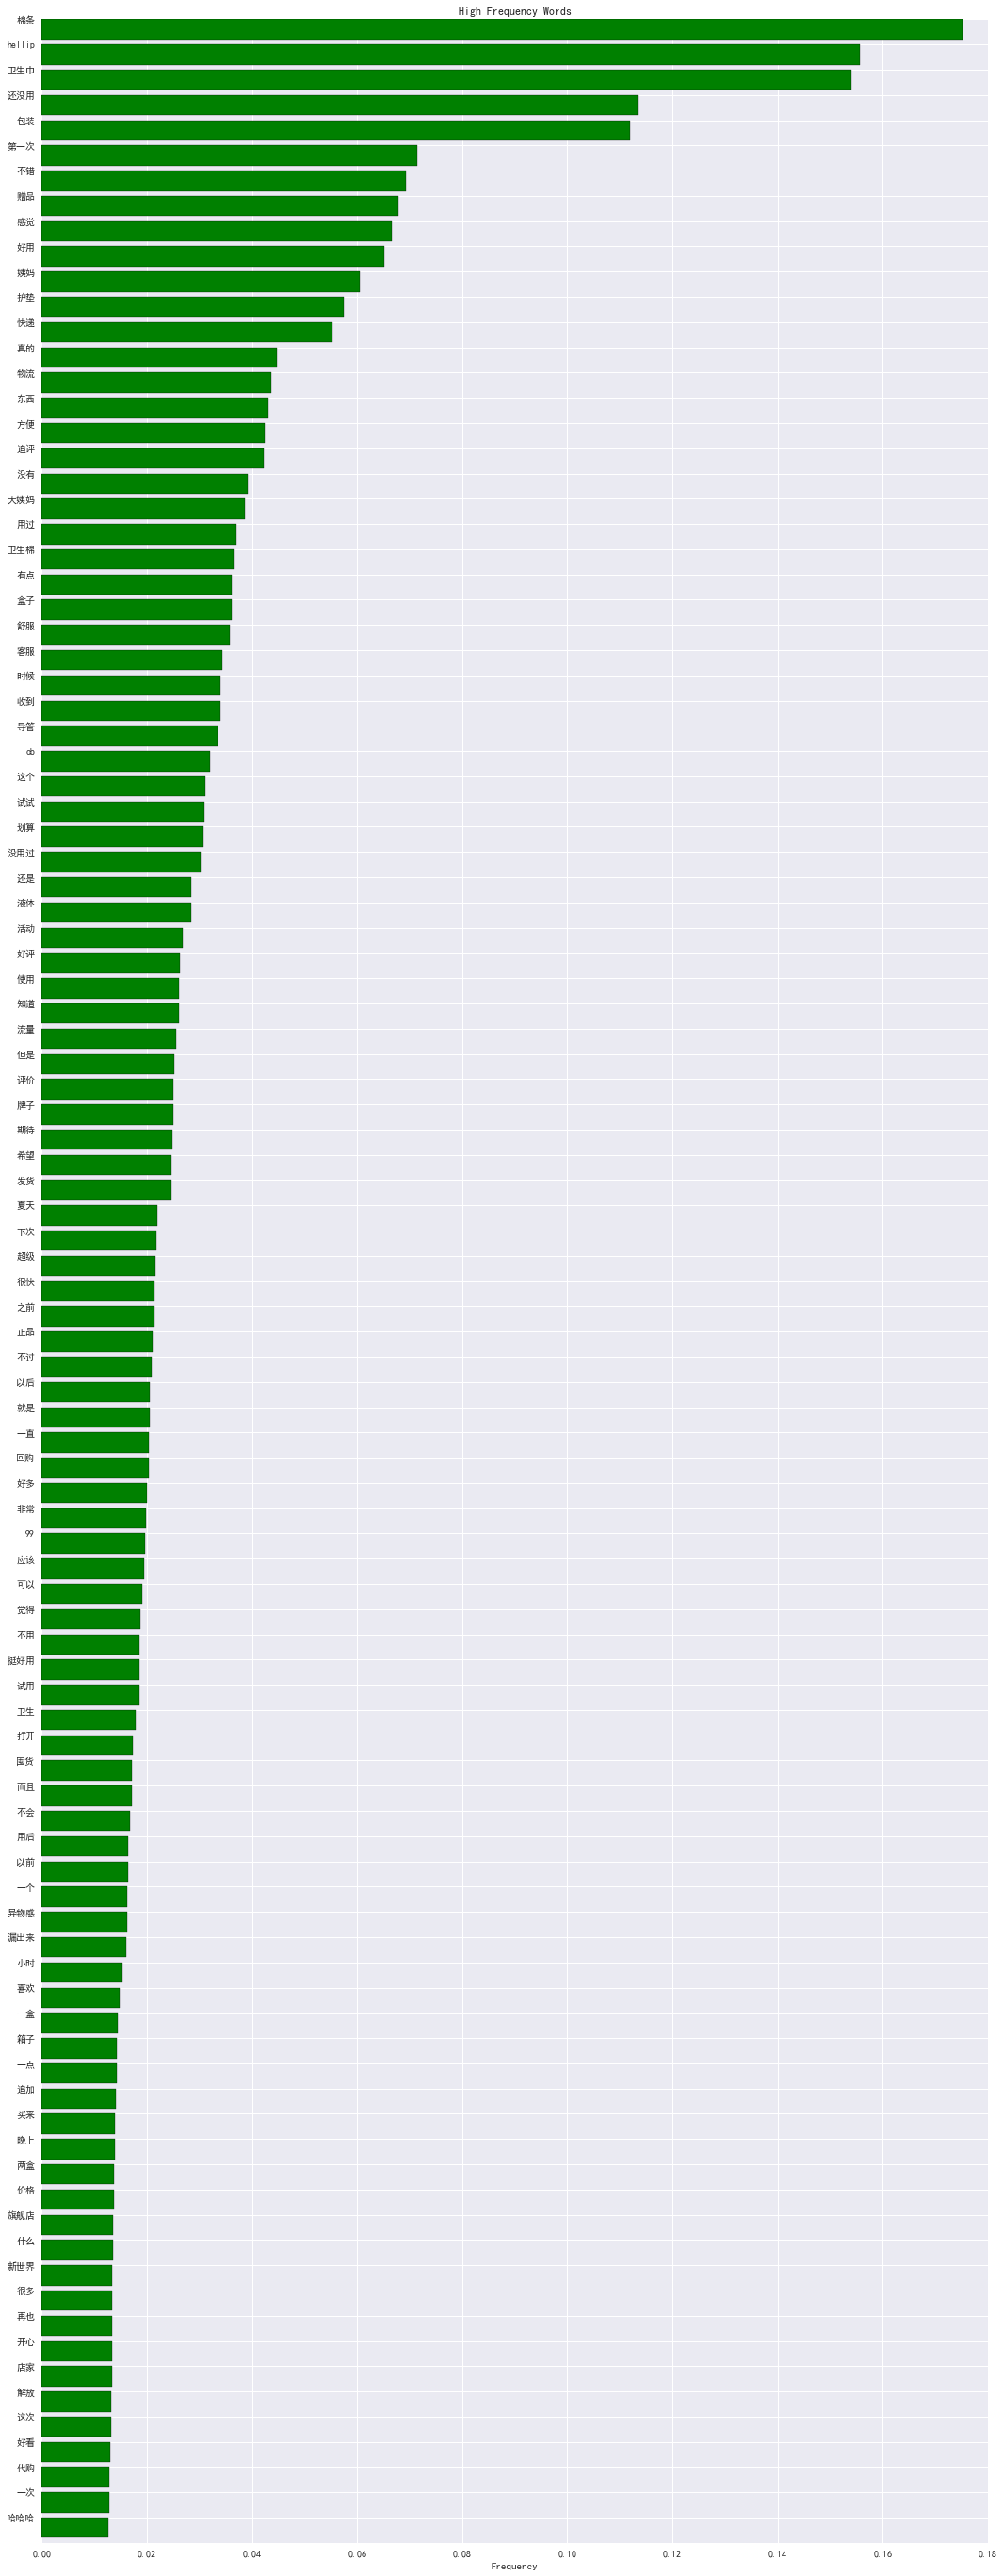

NameError: global name 'grey_color_func' is not defined

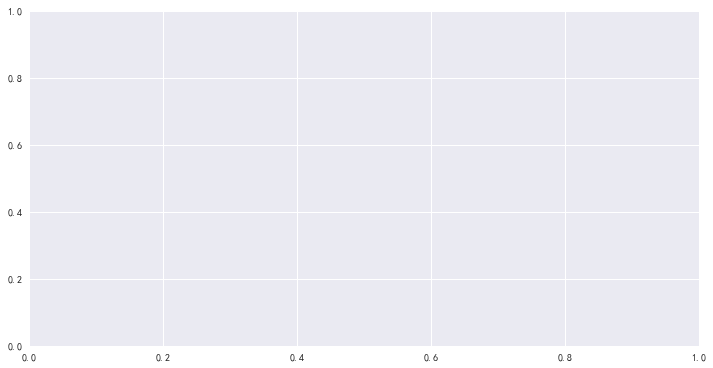

In [6]:
total_content,sku_list = explore('TAMPAX')

In [ ]:
dive(u'包装')